In [1]:
import pandas as pd
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import csv
from sklearn.linear_model import LogisticRegression
import gensim
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
##give the path to triaining data
column_names = ['target','ids','date','flag','user','text']
data = pd.read_csv("training_data.csv",encoding='ISO-8859-1',names=column_names)

In [4]:
#visualizing data
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#droping rows where sentiment is neural as we only going to predict posotive and negative 
data.drop(data[data['target']==2].index,inplace=True)

In [6]:
#only 2 classes
#replacing 4 with 1 because in dataset 4 represent postive sentiment
data['target'] = data['target'].replace(4,1)
data['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

In [7]:
##Filtering negative class data
negative_class_data = data[data['target']==0]
negative_class_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
##Filtering positive class data
postive_class_data = data[data['target']==1]
postive_class_data.head()

,target,ids,date,flag,user,text
800000,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [9]:
##We will use 1Lack smaple of neagtive sentiments
sample1 = negative_class_data.sample(n=100000)
sample1.head()

,target,ids,date,flag,user,text
268768,0,1989471406,Mon Jun 01 01:40:03 PDT 2009,NO_QUERY,gina_pina_14,@aianna21 I don't want either *pushes June aw...
121424,0,1833505015,Sun May 17 23:30:10 PDT 2009,NO_QUERY,NICinNIHON,@andrearlevin don't be bitter! you went to UC...
162139,0,1957479011,Fri May 29 00:37:47 PDT 2009,NO_QUERY,JonasBrothas,"@mrspaulkjonas No, havent heard anything about..."
713335,0,2258804365,Sat Jun 20 16:31:29 PDT 2009,NO_QUERY,roxtues,Finally up...my tummy isn't happy And I real...
431771,0,2064611558,Sun Jun 07 06:43:58 PDT 2009,NO_QUERY,BoltClock,@TheLonelyGnome Too bad my camera has no hope ...


In [10]:
##We will use 1Lack smaple of positive sentiments
sample2 = postive_class_data.sample(n=100000)
sample2.head()

,target,ids,date,flag,user,text
1004128,1,1880384206,Fri May 22 01:02:57 PDT 2009,NO_QUERY,nandasmile,"Playing with fire, will we be able to get rid ..."
865700,1,1677504450,Sat May 02 02:26:03 PDT 2009,NO_QUERY,huisuan,@evilistic thanks yun!
1021218,1,1882524606,Fri May 22 07:01:43 PDT 2009,NO_QUERY,rickbert,@dantull DUDE! Congratulations to you and Ang...
1469706,1,2064938968,Sun Jun 07 07:31:43 PDT 2009,NO_QUERY,TheRaeRae,Good morning Twitterland! Watching Vitas on y...
1013532,1,1881328490,Fri May 22 04:20:14 PDT 2009,NO_QUERY,Tomer90,@dirtysyringe I voted for you


In [11]:
##Concating sample of positive and negative class to make traning data frame
training_data = pd.concat([sample1,sample2]).reset_index(drop=True)
training_data.head()

,target,ids,date,flag,user,text
0,0,1989471406,Mon Jun 01 01:40:03 PDT 2009,NO_QUERY,gina_pina_14,@aianna21 I don't want either *pushes June aw...
1,0,1833505015,Sun May 17 23:30:10 PDT 2009,NO_QUERY,NICinNIHON,@andrearlevin don't be bitter! you went to UC...
2,0,1957479011,Fri May 29 00:37:47 PDT 2009,NO_QUERY,JonasBrothas,"@mrspaulkjonas No, havent heard anything about..."
3,0,2258804365,Sat Jun 20 16:31:29 PDT 2009,NO_QUERY,roxtues,Finally up...my tummy isn't happy And I real...
4,0,2064611558,Sun Jun 07 06:43:58 PDT 2009,NO_QUERY,BoltClock,@TheLonelyGnome Too bad my camera has no hope ...


In [12]:
#dropping unimportant columns
training_data.drop(training_data.columns[[1,2,3,4]], axis = 1, inplace = True)

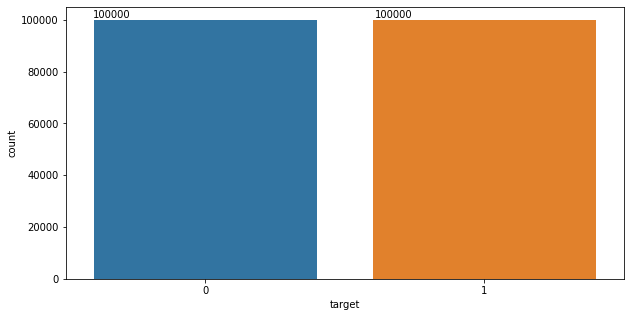

In [13]:
##visualizing number of samples
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
ax=sns.countplot(x='target', data=training_data)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))

In [14]:
#lower case the data
training_data['text'] = training_data['text'].str.lower()
training_data.head()

,target,text
0,0,@aianna21 i don't want either *pushes june aw...
1,0,@andrearlevin don't be bitter! you went to uc...
2,0,"@mrspaulkjonas no, havent heard anything about..."
3,0,finally up...my tummy isn't happy and i real...
4,0,@thelonelygnome too bad my camera has no hope ...


### Text Pre-processsing 

In [15]:

nltk.download('stopwords')


stop = stopwords.words('english')

# removing stopwords
training_data['text'] = training_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training_data.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,target,text
0,0,@aianna21 want either *pushes june away clings...
1,0,"@andrearlevin bitter! went ucf, seems like mag..."
2,0,"@mrspaulkjonas no, havent heard anything show ..."
3,0,finally up...my tummy happy really want go wor...
4,0,@thelonelygnome bad camera hope able capture g...


In [16]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text) # no emoji
    
training_data['text'] = training_data['text'].apply(remove_emojis)
training_data.head() 

,target,text
0,0,@aianna21 want either *pushes june away clings...
1,0,"@andrearlevin bitter! went ucf, seems like mag..."
2,0,"@mrspaulkjonas no, havent heard anything show ..."
3,0,finally up...my tummy happy really want go wor...
4,0,@thelonelygnome bad camera hope able capture g...


In [17]:
#PREPROCESSING USING REGULAR EXPRESSION
def clean_tweets(tweet):    
    # remove URL
    tweet = re.sub(r"http\S+", "", tweet)    
    # Remove usernames
    tweet = re.sub(r"@[^\s]+[\s]?",'',tweet)    
    # Remove hashtags
    #tweet = re.sub(r"#[^\s]+[\s]?",'',tweet)
    tweet = re.sub(r"#",'',tweet) 
    # remove special characters 
    tweet = re.sub('[^ a-zA-Z0-9]', '', tweet)    
    # remove Numbers
    tweet = re.sub('[0-9]', '', tweet)    
    tweet = re.sub(r"^https://t.co/[a-zA-Z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$", " ", tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"that's","that is",tweet)
    tweet = re.sub(r"there's","there is",tweet)
    tweet = re.sub(r"what's","what is",tweet)
    tweet = re.sub(r"where's","where is",tweet)
    tweet = re.sub(r"it's","it is",tweet)
    tweet = re.sub(r"who's","who is",tweet)
    tweet = re.sub(r"i'm","i am",tweet)
    tweet = re.sub(r"she's","she is",tweet)
    tweet = re.sub(r"he's","he is",tweet)
    tweet = re.sub(r"they're","they are",tweet)
    tweet = re.sub(r"who're","who are",tweet)
    tweet = re.sub(r"ain't","am not",tweet)
    tweet = re.sub(r"wouldn't","would not",tweet)
    tweet = re.sub(r"shouldn't","should not",tweet)
    tweet = re.sub(r"can't","can not",tweet)
    tweet = re.sub(r"couldn't","could not",tweet)
    tweet = re.sub(r"won't","will not",tweet)
    tweet = re.sub(r"\W"," ",tweet)
    tweet = re.sub(r"\d"," ",tweet)
    tweet = re.sub(r"\s+[a-z]\s+"," ",tweet)
    tweet = re.sub(r"\s+[a-z]$"," ",tweet)
    tweet = re.sub(r"^[a-z]\s+"," ",tweet)
    tweet = re.sub(r"\s+"," ",tweet)    
    return tweet
# Apply function to Tweet column
training_data['text']  = training_data['text'] .apply(clean_tweets)
training_data.head()

,target,text
0,0,want either pushes june away clings may
1,0,bitter went ucf seems like magic winning horri...
2,0,no havent heard anything show hasnt saturday n...
3,0,finally upmy tummy happy really want go work d...
4,0,bad camera hope able capture good photo


In [18]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
training_data['text'] = training_data['text'].apply(lambda x: cleaning_repeating_char(x))
training_data['text'].head()

0              want either pushes june away clings may
1    bitter went ucf seems like magic winning horri...
2    no havent heard anything show hasnt saturday n...
3    finally upmy tummy happy really want go work d...
4              bad camera hope able capture good photo
Name: text, dtype: object

In [19]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
training_data['text']= training_data['text'].apply(lambda x: stemming_on_text(x))
training_data['text'].head()

0              want either pushes june away clings may
1    bitter went ucf seems like magic winning horri...
2    no havent heard anything show hasnt saturday n...
3    finally upmy tummy happy really want go work d...
4              bad camera hope able capture good photo
Name: text, dtype: object

In [20]:
# Lemmatize the text
import nltk
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

training_data['lemmatized'] = training_data['text'].apply(lemmatize_text)

# Make lemmatized tokens to sentence
training_data['lemmatized_sent'] = training_data['lemmatized'].str.join(' ')
training_data.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,target,text,lemmatized,lemmatized_sent
0,0,want either pushes june away clings may,"[want, either, push, june, away, cling, may]",want either push june away cling may
1,0,bitter went ucf seems like magic winning horri...,"[bitter, went, ucf, seems, like, magic, winnin...",bitter went ucf seems like magic winning horri...
2,0,no havent heard anything show hasnt saturday n...,"[no, havent, heard, anything, show, hasnt, sat...",no havent heard anything show hasnt saturday n...
3,0,finally upmy tummy happy really want go work d...,"[finally, upmy, tummy, happy, really, want, go...",finally upmy tummy happy really want go work d...
4,0,bad camera hope able capture good photo,"[bad, camera, hope, able, capture, good, photo]",bad camera hope able capture good photo


In [21]:
#visualizing training data 
X = training_data.text
X.head()

0              want either pushes june away clings may
1    bitter went ucf seems like magic winning horri...
2    no havent heard anything show hasnt saturday n...
3    finally upmy tummy happy really want go work d...
4              bad camera hope able capture good photo
Name: text, dtype: object

In [22]:
#visualizing test data 
Y = training_data.target
Y.sample(5)

175936    1
44565     0
27337     0
52292     0
191976    1
Name: target, dtype: int64

In [23]:
## Shapes of data
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1, random_state =42,stratify=Y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180000,), (20000,), (180000,), (20000,))

In [25]:
##TFIDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  50000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
X_train = vectoriser.transform(X_train)
X_train

<180000x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 1531337 stored elements in Compressed Sparse Row format>

In [27]:
X_test  = vectoriser.transform(X_test)
X_test

<20000x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 164872 stored elements in Compressed Sparse Row format>

In [34]:
##function for model evaluation
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} : {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     10000
           1       0.75      0.79      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.77      0.76      0.76     20000
weighted avg       0.77      0.76      0.76     20000



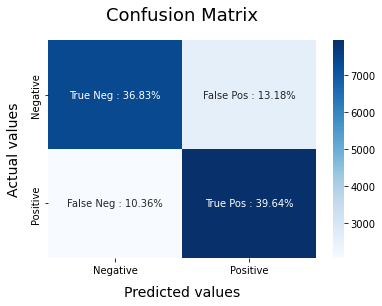

In [35]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

## SVM Model

              precision    recall  f1-score   support

           0       0.77      0.74      0.76     10000
           1       0.75      0.78      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



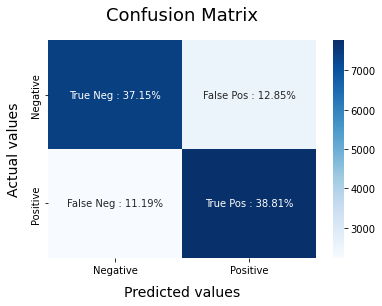

In [36]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

## LR Model

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     10000
           1       0.76      0.79      0.78     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



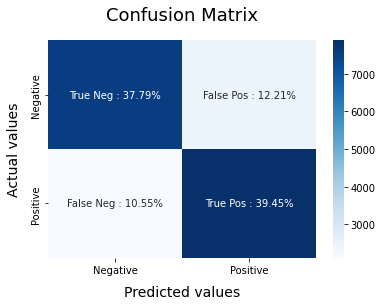

In [37]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

## Prediction on text using BNB Model

In [53]:
tweet_to_predict = "he is very good boy"

In [54]:
##Function for prediction
def predict_Sentiment(tweet):
  tweet = str(tweet.lower())
  tweet = " ".join([word for word in tweet.split() if word not in (stop)])
  tweet = remove_emojis(tweet)
  tweet = clean_tweets(tweet)
  tweet = cleaning_repeating_char(tweet)
  tweet = stemming_on_text(tweet)
  tweet = " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(tweet)])
  prediction = BNBmodel.predict(vectoriser.transform([tweet]))
  print(prediction) 

In [55]:
#1= postive and 0=negative 
predict_Sentiment(tweet_to_predict)

[1]
